# EDA Weather Data

## Setup and Packages

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Import Dataset and First Look

In [2]:
#import data
df = pd.read_csv('../data/neueFische_Wetter.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87672 entries, 0 to 87671
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        87672 non-null  object 
 1   temp        87672 non-null  float64
 2   feels_like  87672 non-null  float64
 3   pressure    87672 non-null  int64  
 4   humidity    87672 non-null  int64  
 5   clouds      87672 non-null  int64  
 6   visibility  84921 non-null  float64
 7   wind_speed  87672 non-null  float64
 8   wind_deg    87672 non-null  int64  
 9   wind_gust   30566 non-null  float64
 10  rain_1h     14258 non-null  float64
 11  snow_1h     1046 non-null   float64
 12  weather_id  87672 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 8.7+ MB


## Extreme Values and Distribution

We can see several missings in visibility, wind_gust, rain_1h and snow_1h.

For the precipitation features, we know these missings are equivalent to zero. wind_gust and visibility need further investigation - we will get to that later.

In [4]:
# replace missings with zeroes for rain and snow
df.rain_1h.fillna(0,inplace=True)
df.snow_1h.fillna(0,inplace=True)

#df.visibility.fillna(10000,inplace=True)

#df.wind_gust.fillna(df.wind_speed,inplace=True)

<AxesSubplot:xlabel='time', ylabel='visibility'>

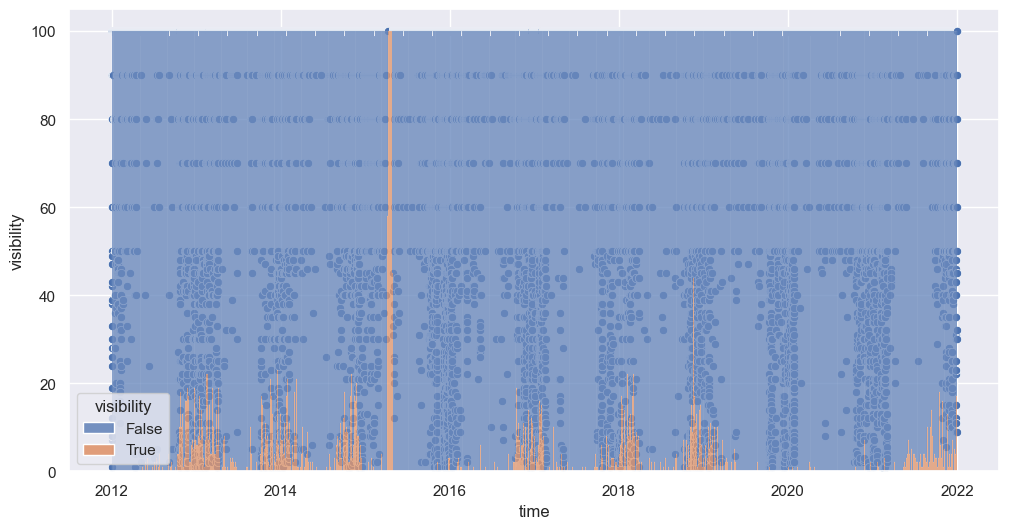

In [26]:
sns.scatterplot(data=df, x='time', y=(df.visibility/100), x_bins=877)#, bins=240, hue=df.visibility.isna())
sns.histplot(data=df, x='time', hue=df.visibility.isna(), bins=877, multiple='stack')

<AxesSubplot:xlabel='time', ylabel='wind_gust'>

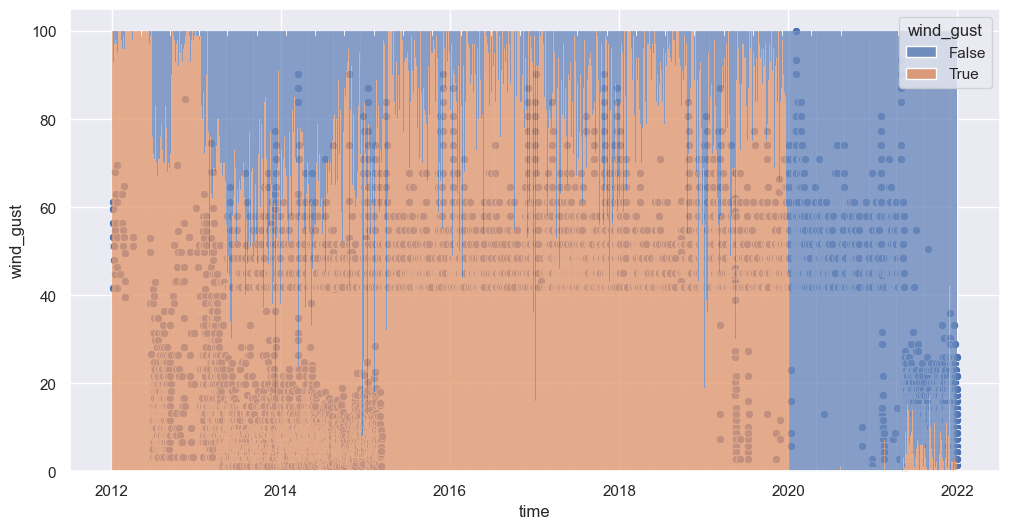

In [27]:
sns.scatterplot(data=df, x='time', y=((df.wind_gust/df.wind_gust.max())*100), x_bins=877)#, bins=240, hue=df.visibility.isna())
sns.histplot(data=df, x='time', hue=df.wind_gust.isna(), bins=877, multiple='stack')

Now let's see whether there are any extreme values in the data

In [5]:
df.describe().T

count         mean          std     min       25%       50%  \
temp        87672.0    12.155226     8.632749  -15.77      5.35     11.89   
feels_like  87672.0    10.876790     9.774918  -22.77      3.18     11.03   
pressure    87672.0  1016.465143     8.097692  975.00   1012.00   1016.00   
humidity    87672.0    70.286066    16.109694   12.00     59.00     72.00   
clouds      87672.0    42.673077    32.650085    0.00     20.00     40.00   
visibility  84921.0  9296.869373  2045.574641   50.00  10000.00  10000.00   
wind_speed  87672.0     3.132998     1.987412    0.00      2.00      3.00   
wind_deg    87672.0   215.922290    97.071699    0.00    140.00    250.00   
wind_gust   30566.0     6.116232     7.105029    0.00      0.00      2.24   
rain_1h     87672.0     0.140110     1.136095    0.00      0.00      0.00   
snow_1h     87672.0     0.008575     0.408635    0.00      0.00      0.00   
weather_id  87672.0   728.965474   127.793008  200.00    701.00    800.00   

                 75%       max  
temp           18.62     38.11  
feels_like     18.29     40.04  
pressure     1021.00   1047.00  
humidity       83.00    100.00  
clouds         75.00    100.00  
visibility  10000.00  10000.00  
wind_speed      4.00     15.00  
wind_deg      300.00    360.00  
wind_gust      14.00     31.00  
rain_1h         0.00     49.78  
snow_1h         0.00     49.28  
weather_id    802.00    804.00

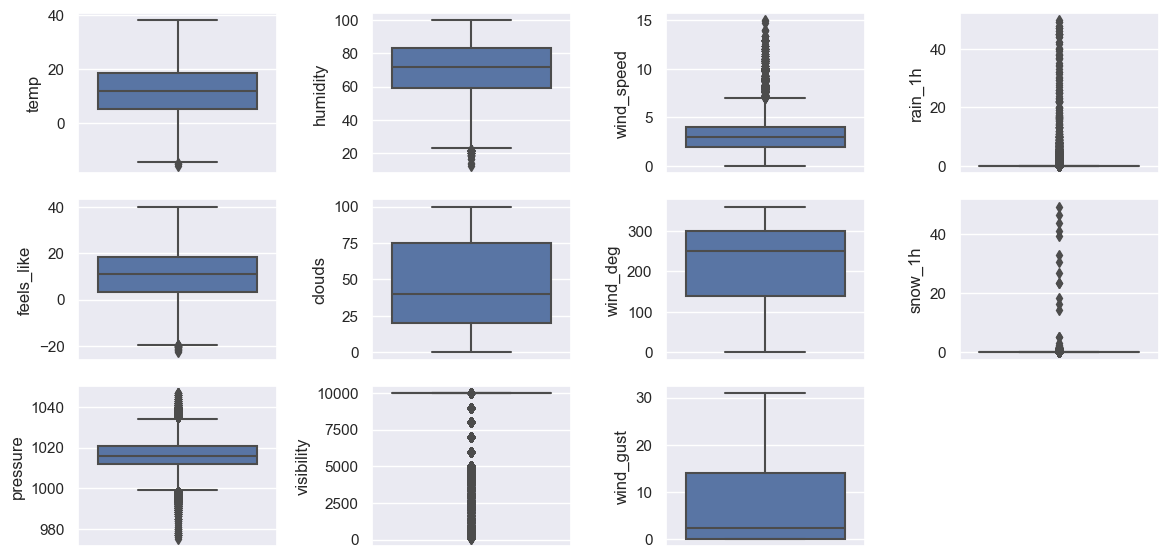

In [6]:
sns.set()
fig, axes = plt.subplots(3,4)
ax=int(0)
ay=int(0)
ay2=0
for e in ['temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h',
       'snow_1h']:  
       sns.boxplot(data=df, y=e, ax=axes[ay,ax])
       ax+=1
       ay2+=1
       ay=int(ay2%3)
       ax=int(ax-ay/4)
fig.tight_layout()
axes[-1, -1].axis('off')
plt.show();

Most features have at least some extreme values. However, at first glance they don't look like they aren't genuine values: They are neither completely out of range nor not accompanied by other values, thus might represent unusual weather. We will keep these data points in for now, but keep them in mind for future model building.

Next, we should investigate whether the data is normally distributed. Since we can expect the distribution to be different by year, we should look at the data yearwise.

In [7]:
#convert time to datetime and extract years, months, and so on.
df.time = df.apply(lambda x: pd.to_datetime(x['time'],utc=True),axis=1)
df = df.assign(
    date = lambda x: x['time'].dt.date,
    year = lambda x: x['time'].dt.year,
    month = lambda x: x['time'].dt.month,
    week = lambda x: x['time'].dt.isocalendar().week,
    day = lambda x: x['time'].dt.day,
    weekday = lambda x: x['time'].dt.weekday,
    dayofyear = lambda x: x['time'].dt.dayofyear,
    hour = lambda x: x['time'].dt.hour,
)
df.weekday.replace({0:'Mo',
                    1:'Tu',
                    2:'We',
                    3:'Th',
                    4:'Fr',
                    5:'Sa',
                    6:'Su'},inplace=True)

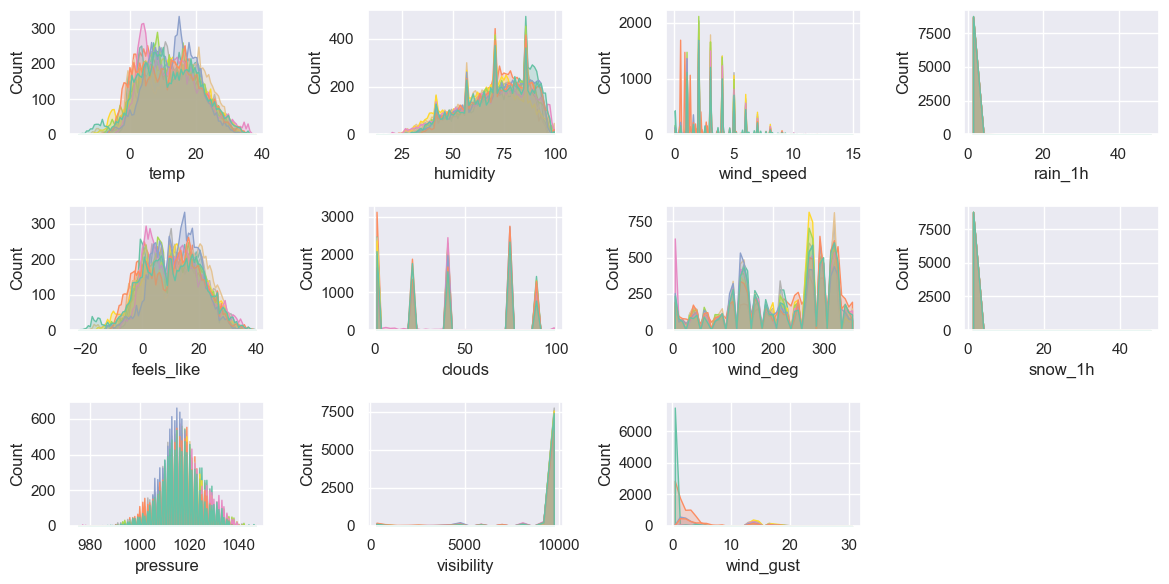

In [8]:
sns.set()
fig, axes = plt.subplots(3,4)
ax=int(0)
ay=int(0)
ay2=0
for e in ['temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h',
       'snow_1h']:  
       sns.histplot(data=df, x=e, ax=axes[ay,ax], hue='year', legend=False, palette='Set2', element='poly')
       ax+=1
       ay2+=1
       ay=int(ay2%3)
       ax=int(ax-ay/4)
fig.tight_layout()
axes[-1, -1].axis('off')
plt.show();

<AxesSubplot:xlabel='temp', ylabel='Count'>

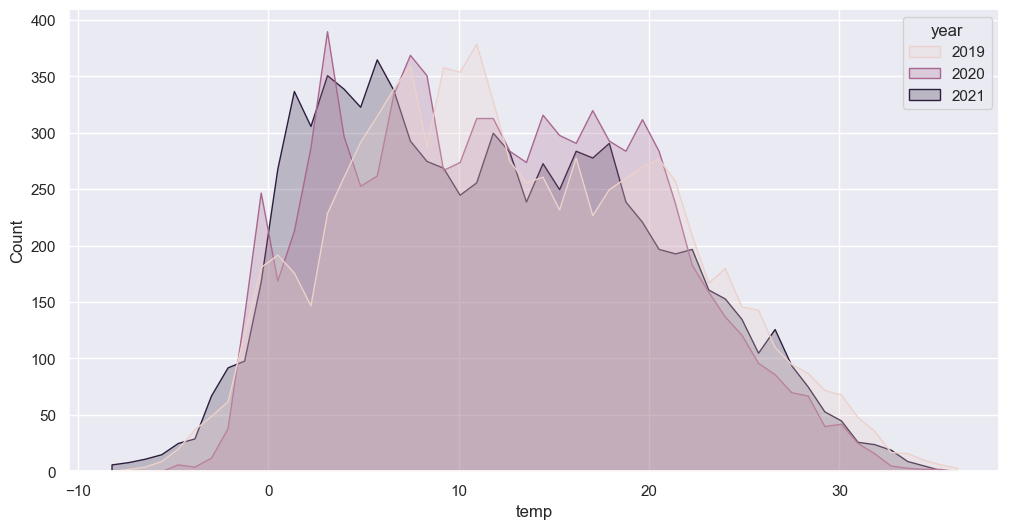

In [9]:
# for better visibility, here's the temperature plot separately for any year
sns.histplot(data=df.loc[df['year']>2018], x='temp', hue='year', element='poly')

We can see that most features are not normally distributed.

## Feature Engineering: Wind and Weather Codes

First, let's take a look at where the wind was most often coming from.

In [25]:
winddata = pd.DataFrame(df[['wind_speed','wind_deg']].value_counts().reset_index())

In [11]:
winddata.columns = ['wind_speed', 'wind_deg', 'frequency']

In [12]:
import plotly.express as px
fig = px.bar_polar(winddata.query('frequency>60'), r='frequency', theta="wind_deg",
                   color="wind_speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   log_r=True)
fig.show()

Most of the time, the location seems to have eastern to north-easterly winds or wind coming from the south-west.

However, the wind data is not in a sensible format for most analyses as it is measured in degrees, ranging from 0 (North) to 360 (also North). So 360 and 0 is the same, not the two extreme ends of a scale. We thus translate wind direction into x and y coordinates.

In [13]:
# Turn wind data into x-y-coordinates
df["wind_dir_x"] = df.wind_deg.apply(lambda x: np.cos(np.array(x) * np.pi /180))
df["wind_dir_y"] = df.wind_deg.apply(lambda x: np.sin(np.array(x) * np.pi /180))

We further now interpret the weather codes by linking them with metadata from a reference table.

In [14]:
codes = pd.read_csv('../data/neueFische_Wettercodes.csv')
codes.columns = ['weather_id', 'WeatherMain', 'WeatherDescription']
df = pd.merge(df, codes, how='left',on='weather_id')

# Time Series EDA

To examine the distribution of weather data over time, we look at precipitation and temperature and compare them by years (from 2017 on, so we can actually see something on the graphs).

<AxesSubplot:xlabel='month', ylabel='rain_1h'>

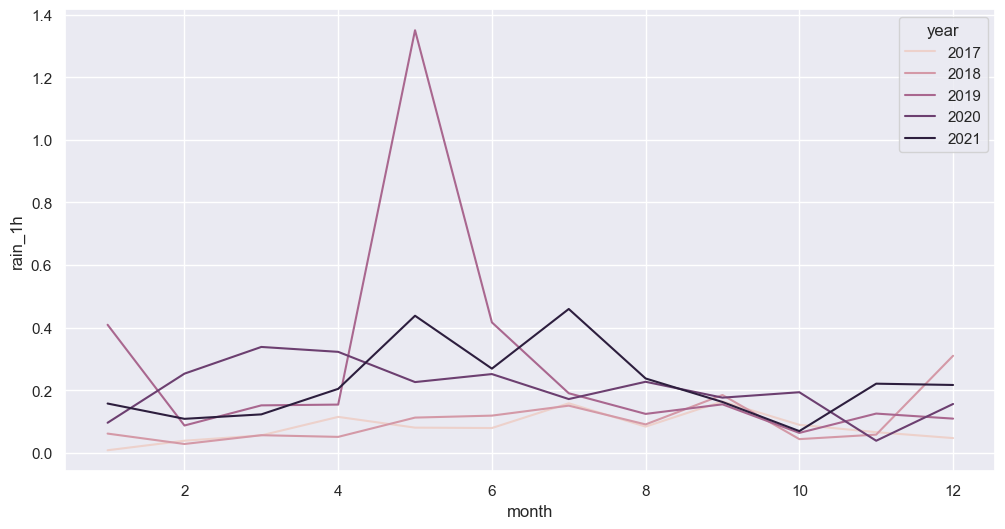

In [15]:
sns.lineplot(data=df.loc[df['year']>2016].groupby(['year','month']).agg('mean'), x='month', y='rain_1h', hue='year')

It seems to rain pretty evenly during the year, with an extreme peak in may 2018.

<AxesSubplot:xlabel='month', ylabel='snow_1h'>

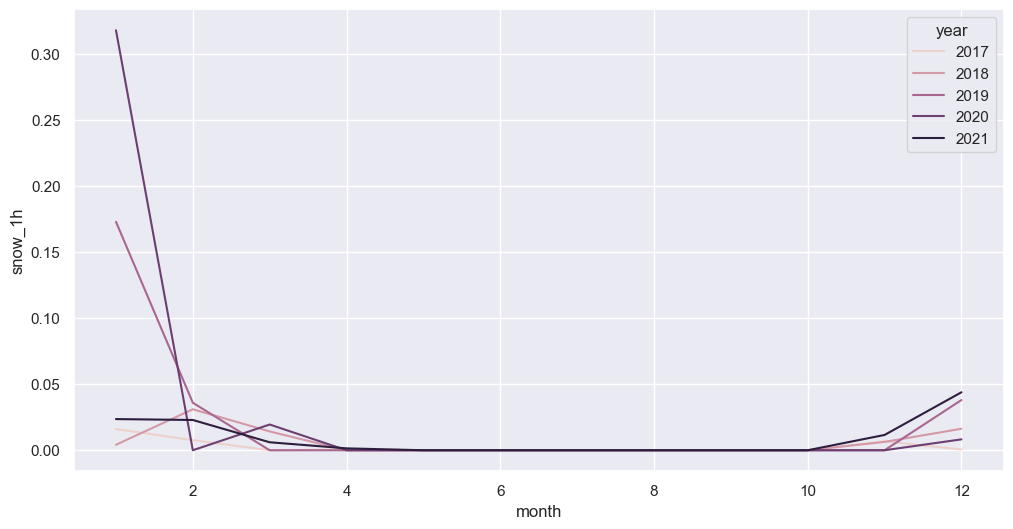

In [16]:
sns.lineplot(data=df.loc[df['year']>2016].groupby(['year','month']).agg('mean'), x='month', y='snow_1h',hue='year')

Snow is, not surprisingly, sparse and falling in january 2019 and 2020 mostly.

<AxesSubplot:xlabel='month', ylabel='feels_like'>

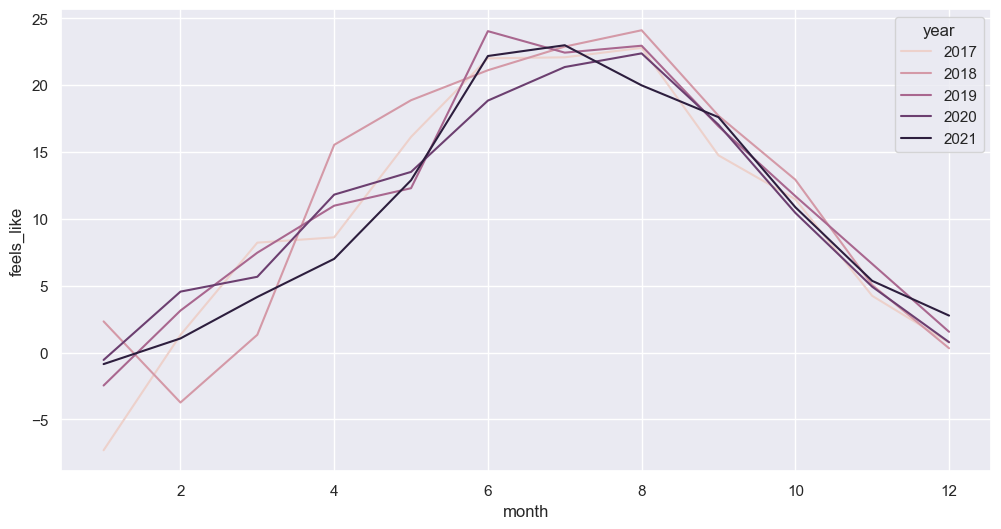

In [17]:
sns.lineplot(data=df.loc[df['year']>2016].groupby(['year','month']).agg('mean'), x='month', y='feels_like',hue='year')

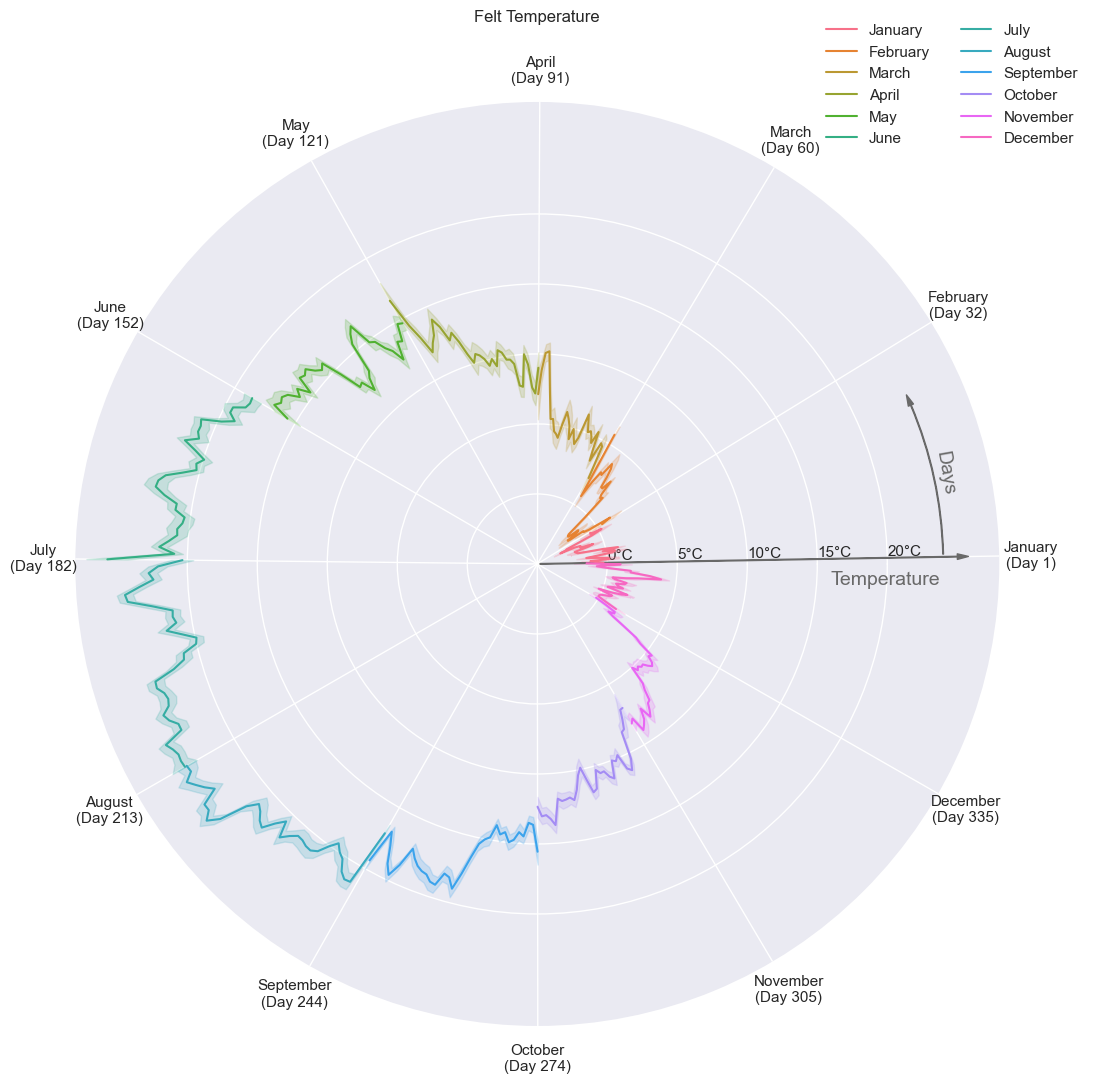

In [18]:
# Polar plot for seasonality 
ax = plt.subplot(111, projection='polar')

# Convert and plot data
df \
    .assign(day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.25)) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='feels_like', 
        hue='month',
        palette=sns.color_palette("husl", 12),
        ax=ax
    )

fancy_plot=True     #this is only to make the plot more beautiful. If you just want to see how the data looks without the adjustments to the plot set fancy_plot to False
if(fancy_plot): 
    days_per_month=[0] + [monthrange(2021, i)[1] for i in range(1,12)]      #findout how many days each month has ()
    month_start=np.cumsum(days_per_month) +1                                #add 1 to start at 0 instead of 0, take the cumsum to get ech months starting day
    month_start_theta=[i *2 * np.pi / 365.25 for i in month_start]          #turn start day into an angle (in rad), use 365.25 as the average length of a year

    month_label=[month_name[i] for i in range(1,13)]
    month_label_long=[label+'\n(Day ' +str(month_start[ind]) +')' for ind,label in enumerate(month_label)]

    ax.set_title('Felt Temperature', va='bottom',pad=22);
    ax.spines.clear()
    
    ax.set_xlabel('')
    ax.set_xticks(month_start_theta)
    ax.set_xticklabels(month_label_long)
    
    ax.set_ylabel('')    
    ax.set_ylim(-5,28)
    ax.set_yticks(yt:=[0,5,10,15,20])
    ax.set_yticklabels([str(t)+'°C' for t in yt], rotation = 45)

    #Arrows / Annotations
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="dimgrey")
    ax.set_rlabel_position(1) 
    ax.text(13*2*np.pi/360,24,"Days",size=14,color='dimgrey',rotation=-80,va='center')
    ax.text(-3*2*np.pi/360,16,"Temperature",size=14,color='dimgrey',rotation=-0,va='center')
    a1 = patches.FancyArrowPatch((1*np.pi/180, -5), (1*np.pi/180, 26), **kw)

    a2 = patches.FancyArrowPatch((1*np.pi/180, 24), (25*np.pi/180, 24),
                                connectionstyle=f"arc3,rad={0.105}", **kw)
    
    ax.add_patch(a1)
    ax.add_patch(a2)


    ax.set_rorigin(-5)
    ax.xaxis.set_tick_params(which='major',pad=10)

    ax.legend(labels=month_label,ncol=2,facecolor='white',edgecolor='white',bbox_to_anchor=(1.1, 1.1), loc=1)

    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(12)


ax.figure.savefig("../images/Temp_polar.png",dpi=300)

In general, from June to September, we can expect temperatures to go past 20 degrees on average, while they regularly drop below zero in January and February.

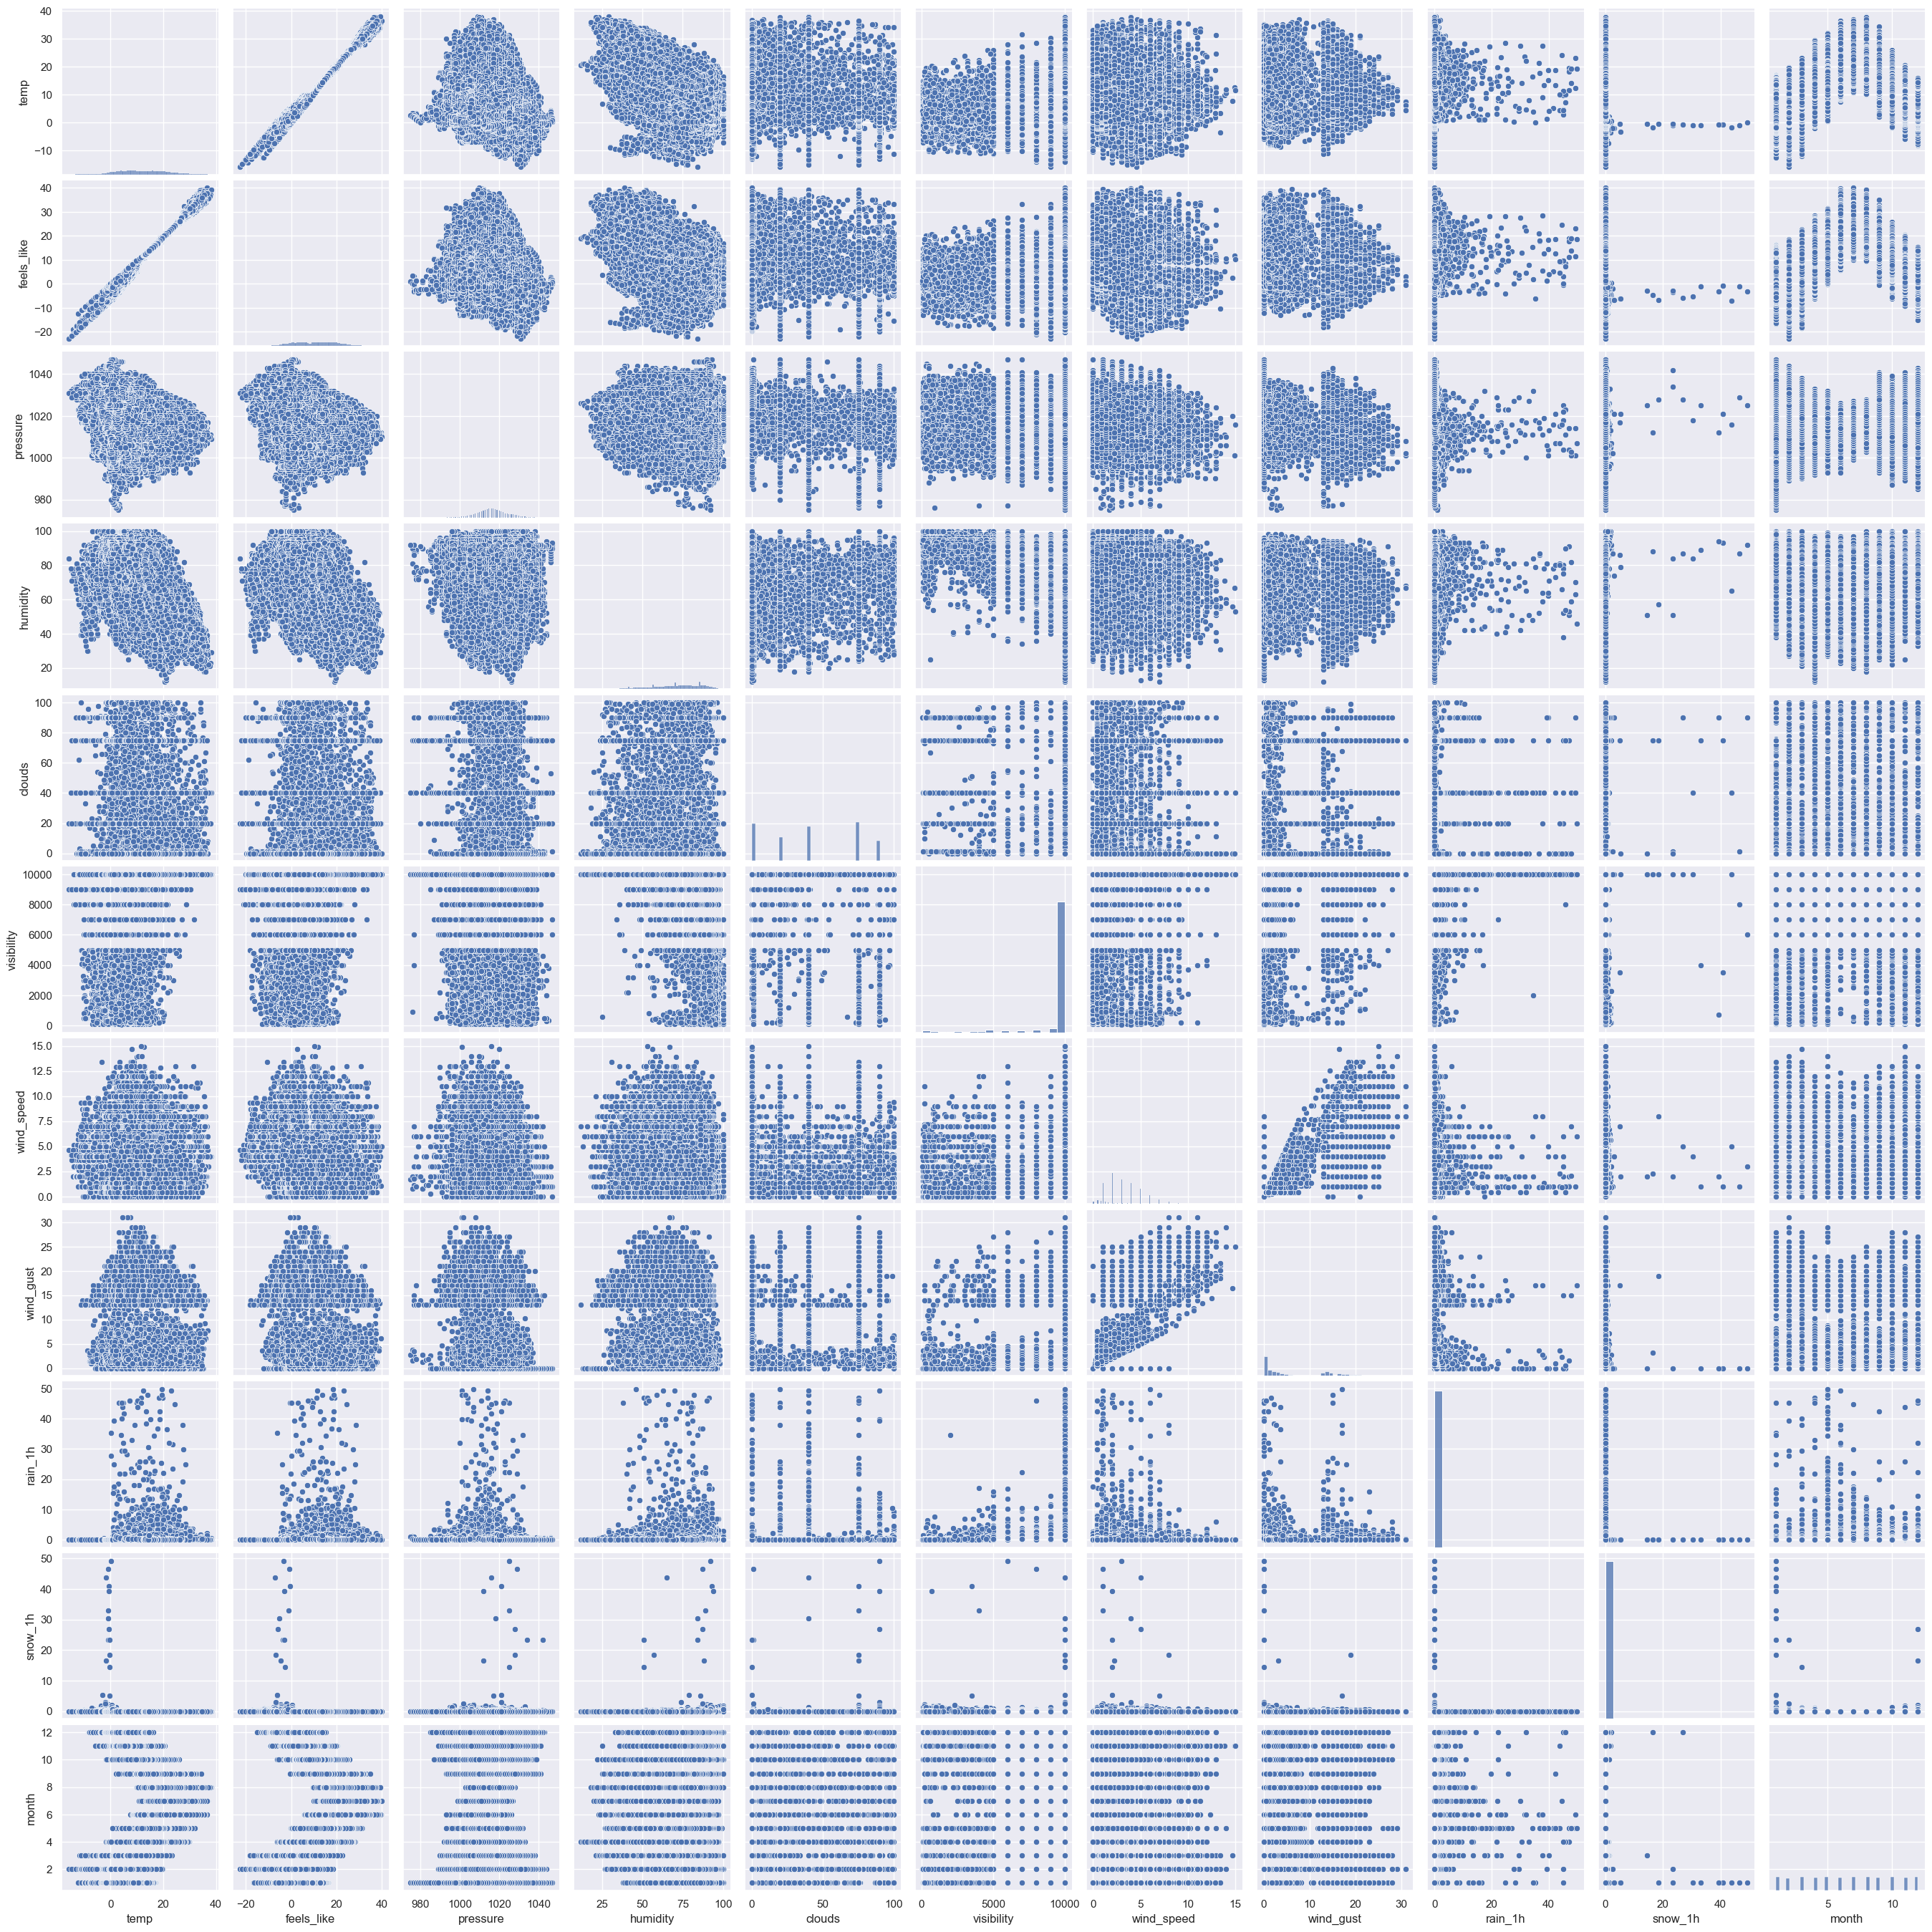

In [19]:
sns.pairplot(df[['temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_gust', 'rain_1h',
       'snow_1h', 'month']])

In [20]:
params = ['temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_gust', 'rain_1h',
       'snow_1h', 'wind_dir_x', 'wind_dir_y']

In [21]:
df.columns

Index(['time', 'temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h',
       'snow_1h', 'weather_id', 'date', 'year', 'month', 'week', 'day',
       'weekday', 'dayofyear', 'hour', 'wind_dir_x', 'wind_dir_y',
       'WeatherMain', 'WeatherDescription'],
      dtype='object')

### Exploring Seasonality and Overall Trends

First, let's get an idea of how the different features behave over the course of a year by smoothening the data at a monthly rolling average.

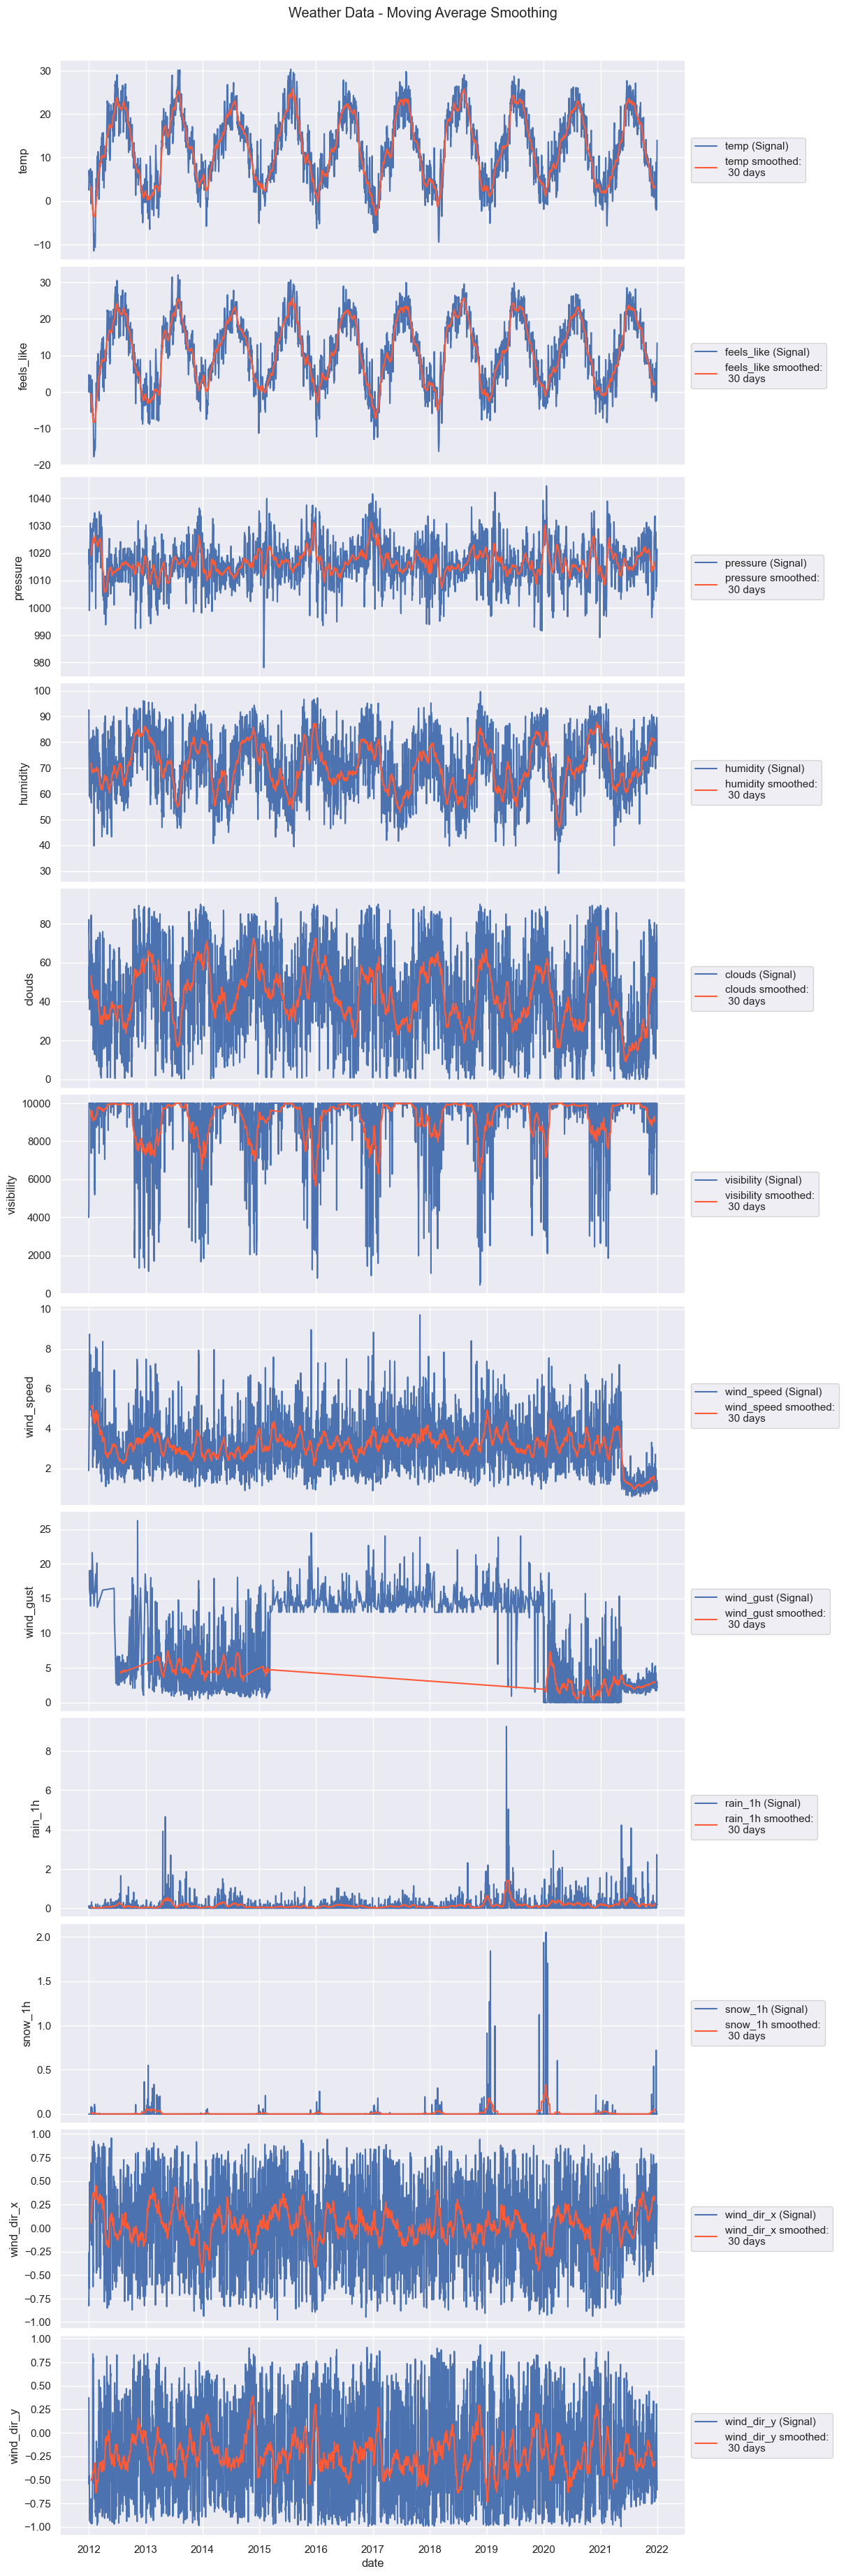

In [22]:
# Plot different weather features over the course of time

# Smooth and plot
fig, ax = plt.subplots(len(params), 1, figsize=(12, 3*len(params)), constrained_layout=True, sharex=True)
plt.suptitle('Weather Data - Moving Average Smoothing', y=1.02);

smooth_df = df.groupby('date').agg('mean')

for i, e in enumerate(params):
    smooth_df[f'{e}_smooth_ma_30d'] = smooth_df[f'{e}'].rolling(window=30,center=True).mean() #compute the rolling mean
    sns.lineplot(x='date', y=f'{e}', label=f'{e} (Signal)', data=smooth_df,  ax=ax[i])
    sns.lineplot(x='date', y=f'{e}_smooth_ma_30d', label=f'{e} smoothed:\n 30 days', data=smooth_df, color=NF_ORANGE, ax=ax[i])

    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='');

    
fig.savefig("../images/Weather_MA_Smoothing.png",dpi=300)

Apart from the fact that we can clearly see that something is off with our wind speed and -gust data here (the data looks different from May 2021 on, and wind gusts further are very odd between spring 2015 and the end of 2019), there are some very clear sesasonal patterns in almost all features.

We can decompose them in further plots.

We start with a yearly cycle:

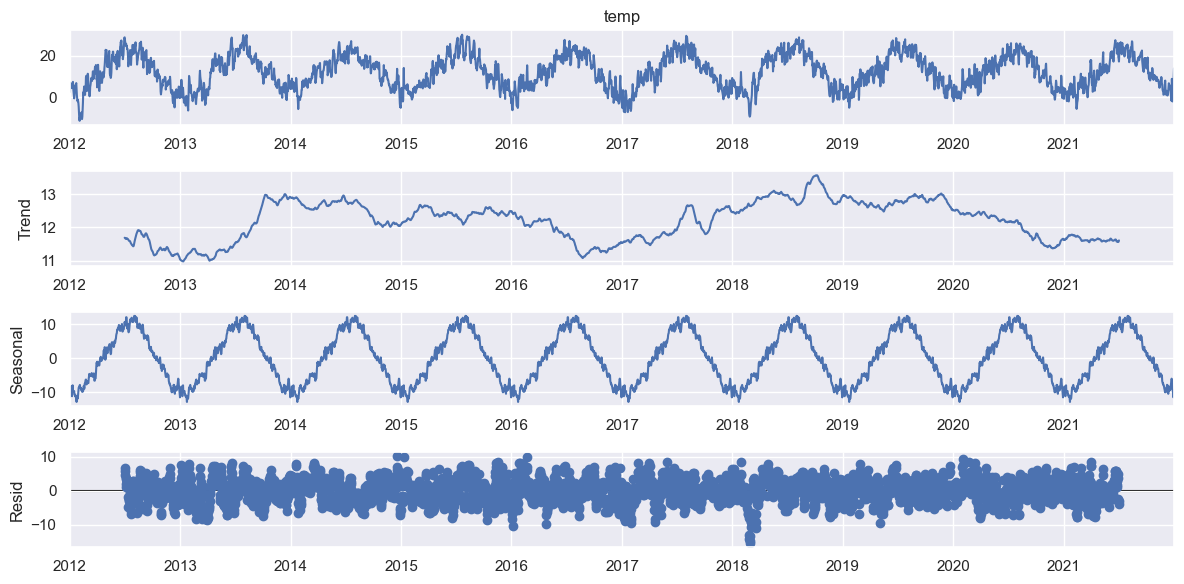

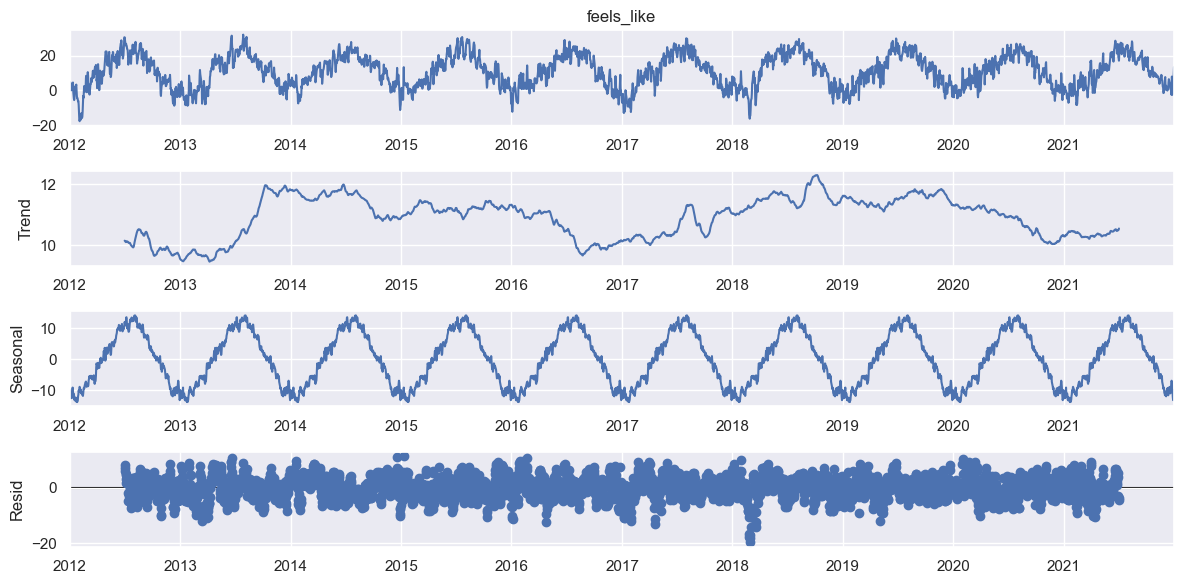

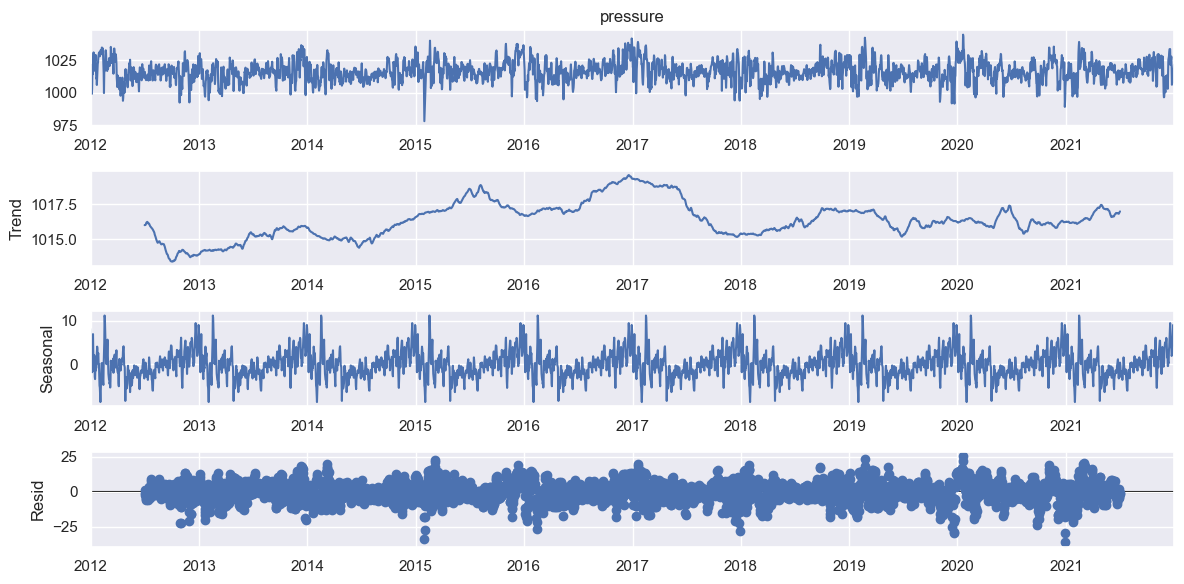

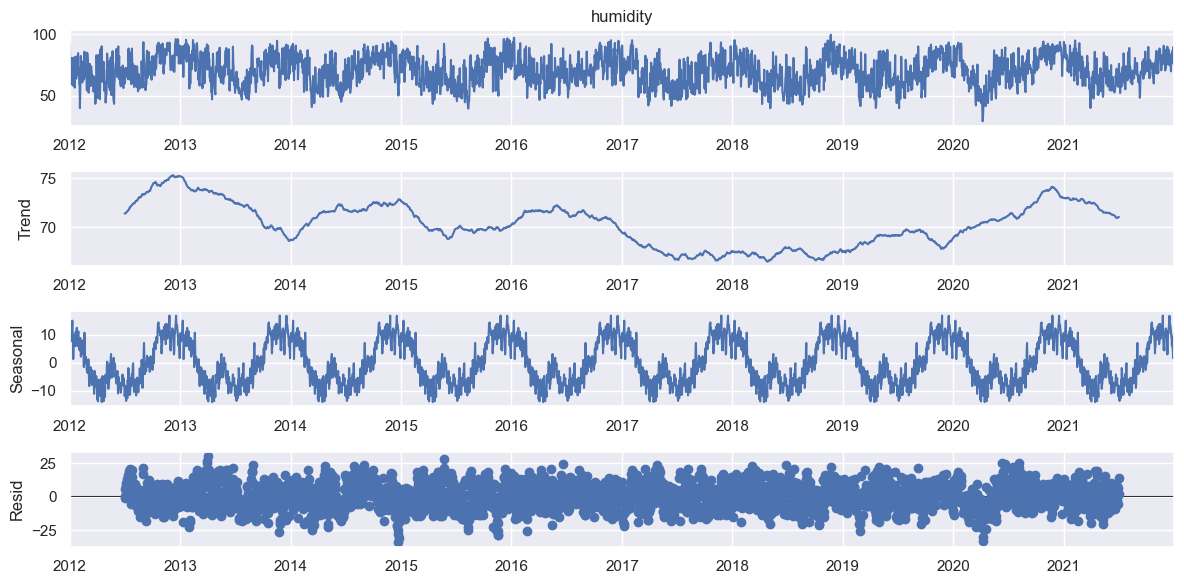

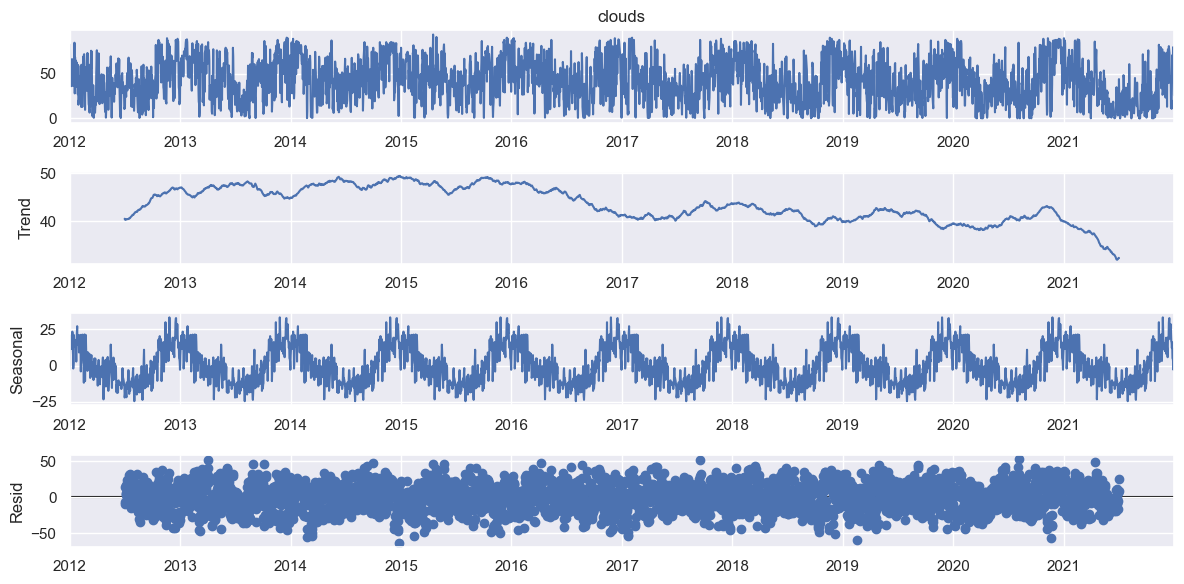

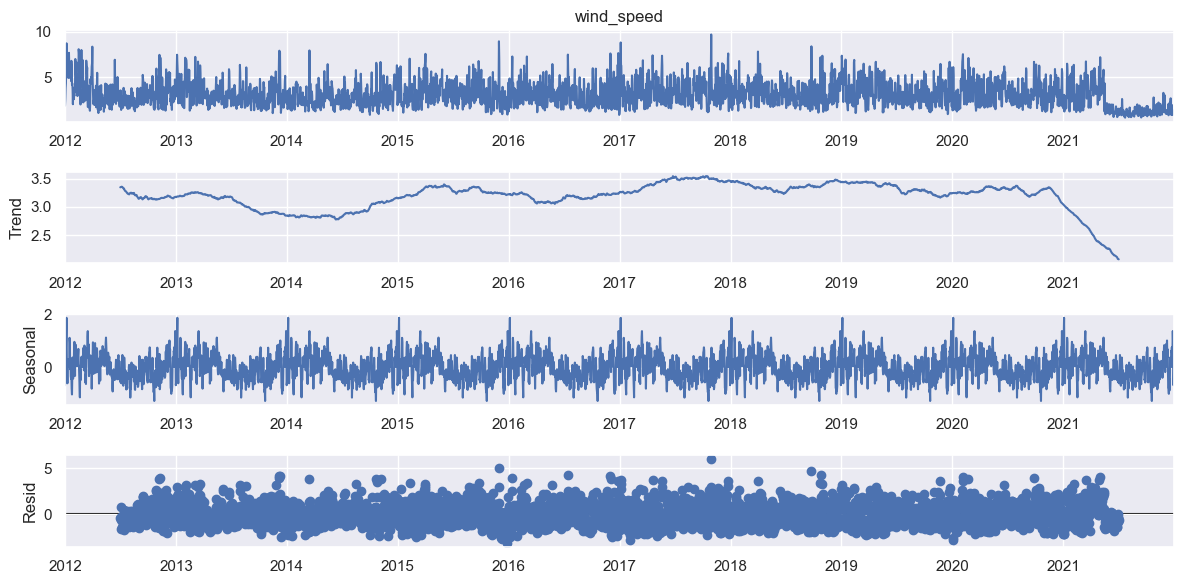

In [23]:
elms=['temp',
 'feels_like',
 'pressure',
 'humidity',
 'clouds',
 #'visibility',
 'wind_speed',
 #'wind_gust',
 #'vislies'
 ]
 
for i, e in enumerate(elms):
    seasonal_decompose(x=df.groupby('date').agg('mean')[f'{e}'], #we use the daily mean instead of the hourly values to keep the plots readable
                        model='additive', 
                        two_sided=True,
                        period=365
                        ).plot()

As expected, we can identify clear seasonal patterns for most features.

Then, we inspect daily cycles:

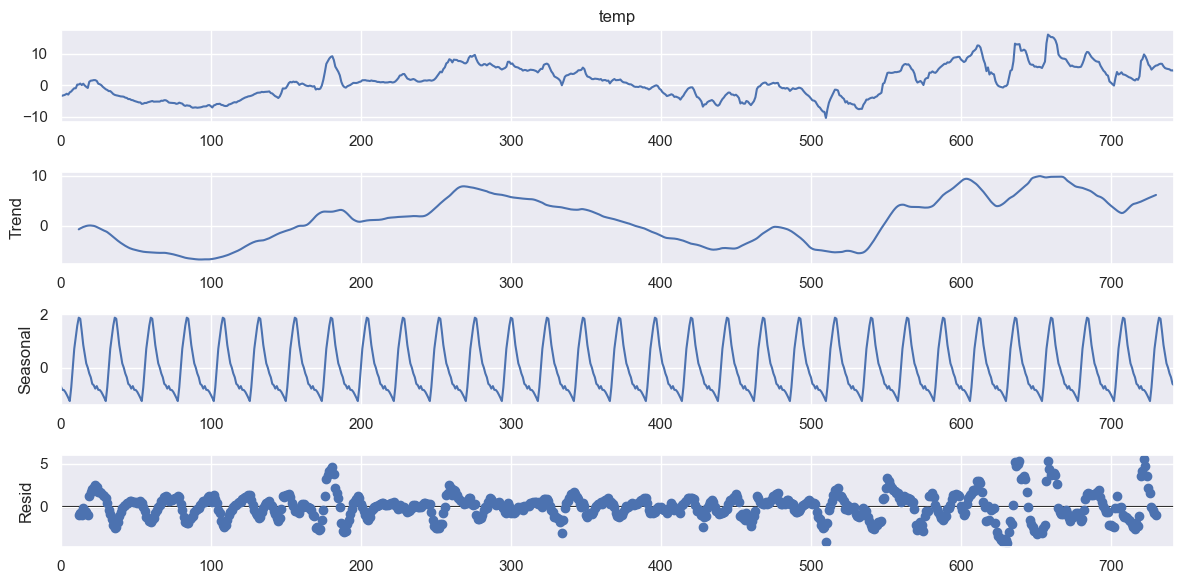

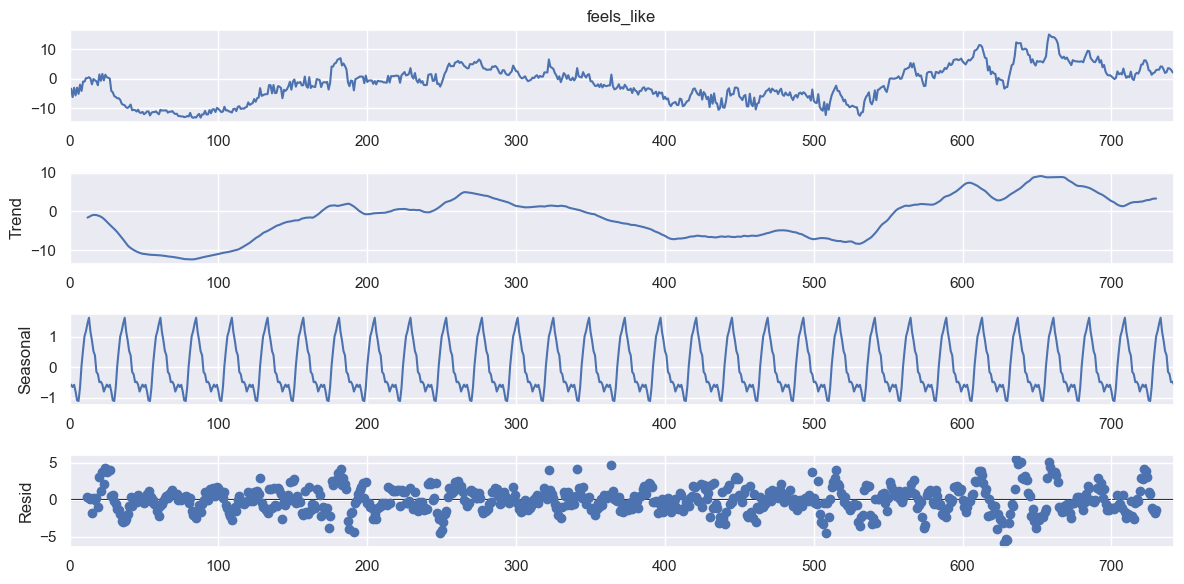

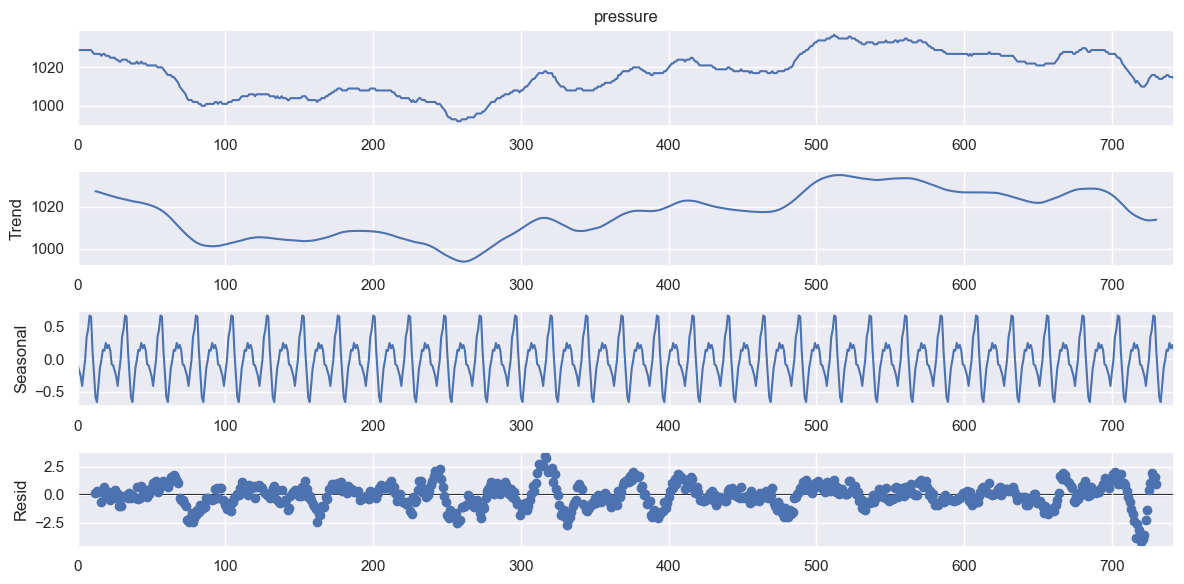

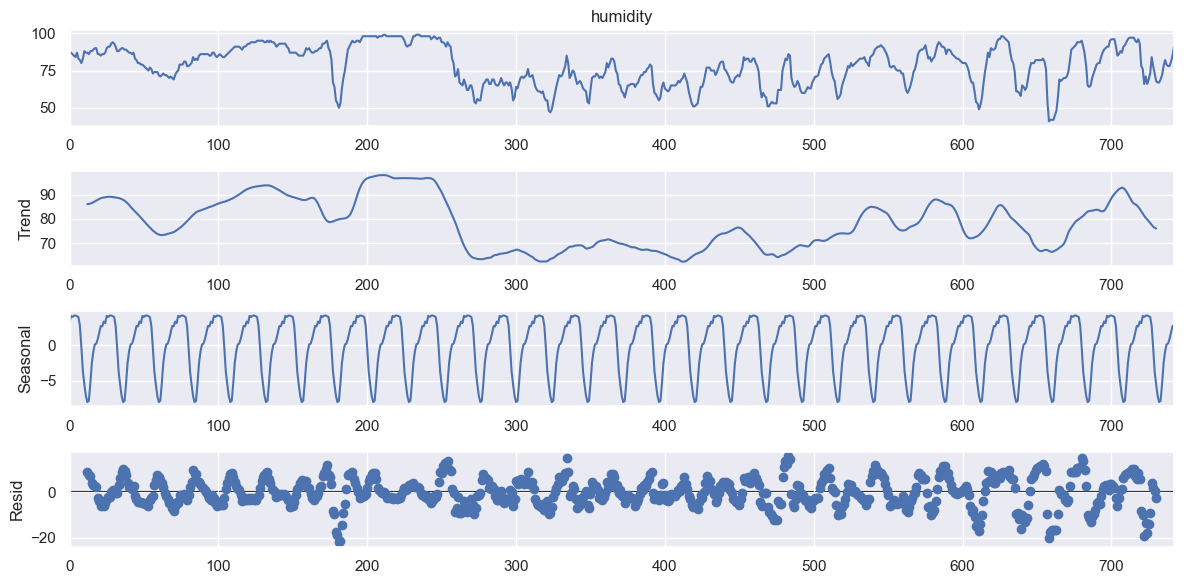

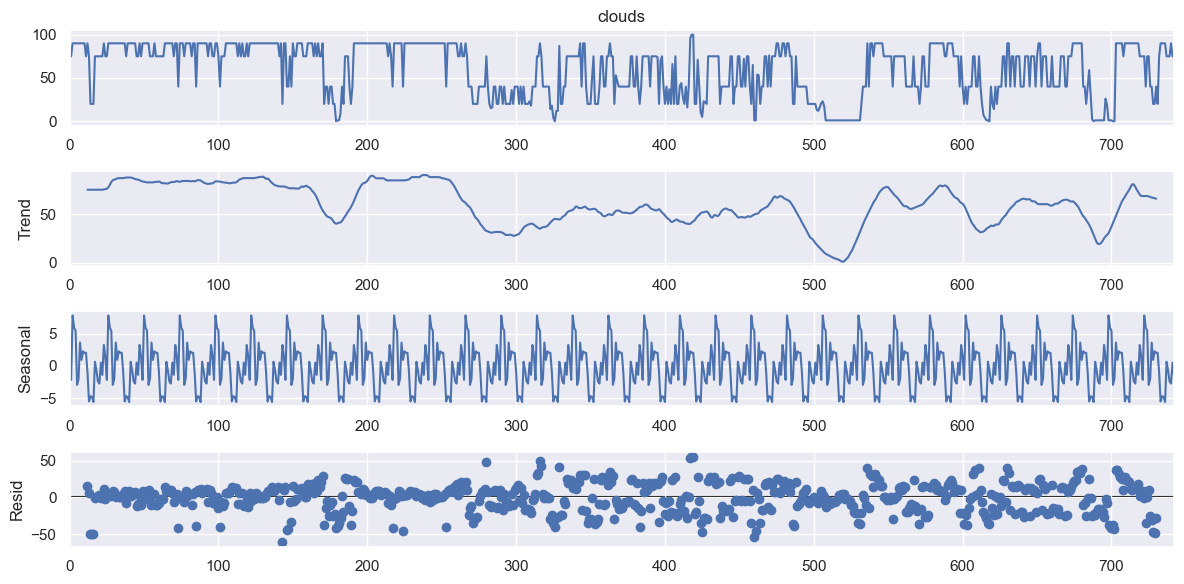

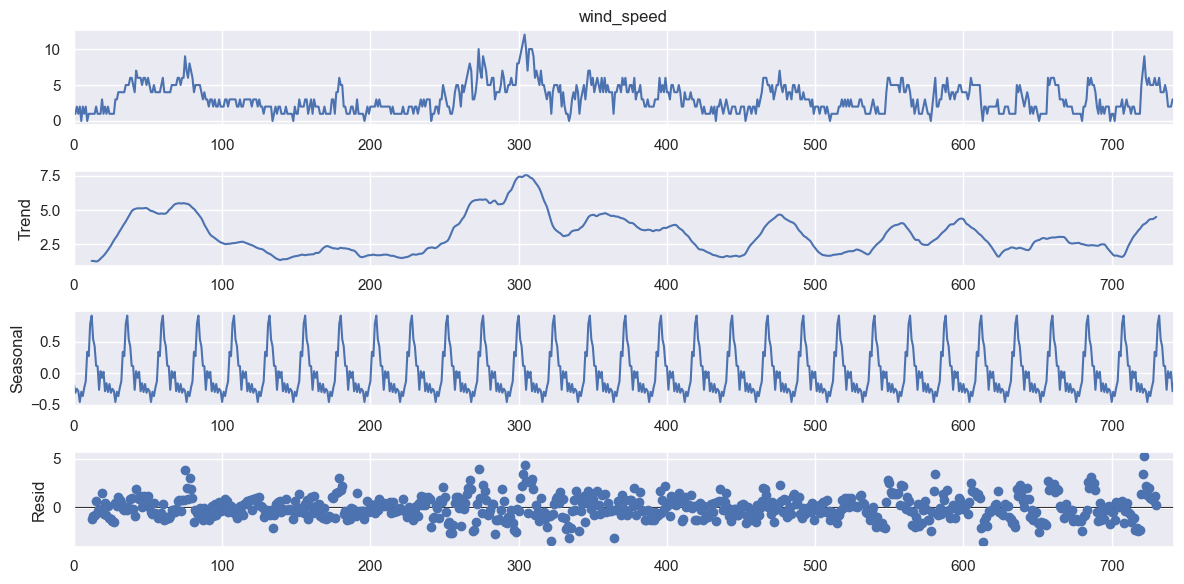

In [24]:
#daily cycle

#since the graph otherwise gets unreadable, it's necessary to only use a subset of data, like one or two months.
p_start='2016-07-01'
p_end='2016-08-01'

#to get a better estimate of the daily cycle, you can enter another timespan here (preferrably 6 months earlier or later) that will also be included in the analysis. 
# If you want to do this, set comparison = True
comparison = False
p_start2='2016-01-01'
p_end2='2016-02-01'

if not comparison:
    p_start, p_end = p_start2, p_end2

elms=['temp',
 'feels_like',
 'pressure',
 'humidity',
 'clouds',
 #'visibility',
 'wind_speed',
 #'wind_gust',
 #'vislies'
 ]

for i, e in enumerate(elms):
    seasonal_decompose(x=df.loc[(df['time']>p_start)&(df['time']<p_end)|(df['time']>p_start2)&(df['time']<p_end2)].reset_index()[f'{e}'], 
                        model='additive', 
                        two_sided=True,
                        period=24
                        ).plot()

Here we see that although we can discover seasonal patterns in almost all features, some of the residual plots still exhibit recurring patterns. Further analysis needs to clarify where they come from.